In [1]:
import os
from datetime import datetime
import sys
sys.path.append("../scripts/twitter")
import utils as ut

from searchTwitter import TwitterDataFrame

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

import re

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix, accuracy_score

from imblearn.over_sampling import SMOTE

np.random.seed(23)

# Set up sns
sns.set(rc = {'figure.figsize':(10,10)})
sns.set_style("whitegrid")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Nick\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# Reads files in a directory as csv and returns dataframe
def concat_data(base_dir):
    files = os.listdir(base_dir)
    dfs = []
    for f in files:
        dfs.append(pd.read_csv(base_dir + f))
        
    return pd.concat(dfs)

sf_df_raw = concat_data('../data/san_francisco/')

# Turn into a TwitterDataFrame and zoom in on san francisco
sf_df_raw = TwitterDataFrame(sf_df_raw)

sf_df_raw.head()

C:\Users\Nick\AppData\Local\Temp/ipykernel_15700/3815770650.py:6: DtypeWarning: Columns (0,1) have mixed types. Specify dtype option on import or set low_memory=False.
  dfs.append(pd.read_csv(base_dir + f))


,id,author_id,text,geo,created_at,lat,lon
0,968999128641323008,25624940,@Volker_E Am I hallucinating that you are walk...,{'place_id': '5a110d312052166f'},2018-02-28 23:59:30,37.708075,-122.514926
1,968999100757680128,8888,There’s just something weird about living in N...,{'place_id': '5ef5b7f391e30aff'},2018-02-28 23:59:23,37.845953,-122.324818
2,968999065273774080,1557223812,Tomorrow’s March sheeeesh I’m basically 24 😕 t...,{'place_id': '5ecbd073f39c00fa'},2018-02-28 23:59:14,37.592632,-122.160814
3,968999056537088000,1164993320,Wednesday really be draining 6-6 school day 😴,{'place_id': '5ecbd073f39c00fa'},2018-02-28 23:59:12,37.592632,-122.160814
4,968999038493245440,18650764,@remedy415 @Brycesavoy510 This hella dope,{'place_id': 'ab2f2fac83aa388d'},2018-02-28 23:59:08,37.699279,-122.342660


In [3]:
# Take a random subsample of the dataframe to reduce the size
sf_df_raw = sf_df_raw.sample(1000000, replace=True).dropna().reset_index(drop=True)

# Ideally this should be before sampling but this way saves time
# Could this happen in TwitterDataFrame?
sf_df_raw['created_at'] = [datetime.strptime(d,'%Y-%m-%d %H:%M:%S') for d in sf_df_raw['created_at']]

# Subset 5/2018-12/2018
sf_df_raw = sf_df_raw[sf_df_raw['created_at'] > datetime(2018, 4, 30)]

# Change date quantum to day
sf_df_raw['date'] = sf_df_raw['created_at'].dt.floor('d')

sf_df = TwitterDataFrame(sf_df_raw)
sf_df.head()

,id,author_id,text,geo,created_at,lat,lon,date
0,992231829812920320,78663,"@Gdowler I am against it on *my* pizza, but I ...",{'place_id': 'ab2f2fac83aa388d'},2018-05-04 02:37:57,37.699279,-122.342660,2018-05-04
1,1047959161630162945,125839769,@FMallicoatKTVU I wanted to see our Sox in Oak...,{'place_id': '5a110d312052166f'},2018-10-04 21:18:28,37.708075,-122.514926,2018-10-04
2,1067722169080176640,333534114,Sarahi: gone \nSleeping: naked \nGo: Bears,{'place_id': '5ef5b7f391e30aff'},2018-11-28 10:09:37,37.845953,-122.324818,2018-11-28
3,1010802730946838528,2524372416,@westcoastbjsfan @VikoNomaaea @MDcoach21 Pat C...,{'place_id': '746cc5651750e057'},2018-06-24 08:32:05,37.634511,-122.471871,2018-06-24
4,1041911294608072704,386942509,I’m a real asshole when I’m drunk &amp; it mak...,{'place_id': 'ab2f2fac83aa388d'},2018-09-18 04:46:25,37.699279,-122.342660,2018-09-18


In [4]:
# What are the basics of this data set?
print("Lenth: ", len(sf_df))
print("Per day :", len(sf_df)/365)

Lenth:  804321
Per day : 2203.619178082192


Text(0.5, 0, 'Date')

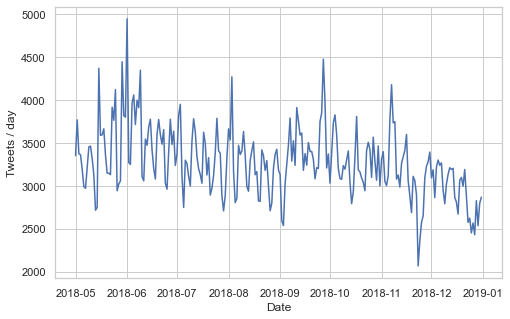

In [5]:
# Plot num tweets per day by date
plt.figure(figsize=(8,5))
plt.plot(sf_df.count_by_day())
ax = plt.gca()
ax.set_ylabel("Tweets / day")
ax.set_xlabel("Date")

In [6]:
# Read in the daily AQI in 2018 California
aqi_2018 = pd.read_csv('../data/daily_aqi_by_county_2018.csv')

# Subset just SF country and extract dates
sf_aqi = aqi_2018[(aqi_2018['State Name']=='California') & (aqi_2018['county Name']=='San Francisco')]
sf_aqi['Date'] = pd.to_datetime(sf_aqi['Date'])

sf_aqi.head()

C:\Users\Nick\AppData\Local\Temp/ipykernel_15700/2893133138.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sf_aqi['Date'] = pd.to_datetime(sf_aqi['Date'])


,State Name,county Name,State Code,County Code,Date,AQI,Category,Defining Parameter,Defining Site,Number of Sites Reporting
27443,California,San Francisco,6,75,2018-01-01,72,Moderate,PM2.5,06-075-0005,1
27444,California,San Francisco,6,75,2018-01-02,82,Moderate,PM2.5,06-075-0005,1
27445,California,San Francisco,6,75,2018-01-03,111,Unhealthy for Sensitive Groups,PM2.5,06-075-0005,1
27446,California,San Francisco,6,75,2018-01-04,58,Moderate,PM2.5,06-075-0005,1
27447,California,San Francisco,6,75,2018-01-05,26,Good,NO2,06-075-0005,1


In [7]:
# Merge AQI and tweet dateframes
sf_mrg = pd.merge(left=sf_df, right=sf_aqi, left_on='date', right_on='Date', how='inner')

sf_mrg.head()

,id,author_id,text,geo,created_at,lat,lon,date,State Name,county Name,State Code,County Code,Date,AQI,Category,Defining Parameter,Defining Site,Number of Sites Reporting
0,992231829812920320,78663,"@Gdowler I am against it on *my* pizza, but I ...",{'place_id': 'ab2f2fac83aa388d'},2018-05-04 02:37:57,37.699279,-122.342660,2018-05-04,California,San Francisco,6,75,2018-05-04,33,Good,Ozone,06-075-0005,1
1,992516470599925760,28743611,Bing watching DC’s Arrow and like I can’t expr...,{'place_id': '5a110d312052166f'},2018-05-04 21:29:01,37.708075,-122.514926,2018-05-04,California,San Francisco,6,75,2018-05-04,33,Good,Ozone,06-075-0005,1
2,992236215779844097,22048160,@chris_mrtn Congrats!!!,{'place_id': 'ab2f2fac83aa388d'},2018-05-04 02:55:23,37.699279,-122.342660,2018-05-04,California,San Francisco,6,75,2018-05-04,33,Good,Ozone,06-075-0005,1
3,992418828536729600,355522298,Alameda CA Fri May 4th AM Forecast: TODAY Most...,"{'place_id': '000e96b4e9f8503f', 'coordinates'...",2018-05-04 15:01:01,37.774800,-122.276500,2018-05-04,California,San Francisco,6,75,2018-05-04,33,Good,Ozone,06-075-0005,1
4,992210809538338817,155960922,"@Jarrett_Lerner @CarterHiggins Wow, thank you ...",{'place_id': '5a110d312052166f'},2018-05-04 01:14:26,37.708075,-122.514926,2018-05-04,California,San Francisco,6,75,2018-05-04,33,Good,Ozone,06-075-0005,1


In [8]:
text_cleaning_re = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"
stop_words = stopwords.words('english')

stemmer = SnowballStemmer('english')

def process_tweet(tweet):
    tweet = re.sub(text_cleaning_re, ' ', str(tweet).lower()).strip()
    tokens = []
    for token in tweet.split():
        if token not in stop_words:
            tokens.append(stemmer.stem(token))
    return ' '.join(tokens)

sf_mrg['text'] = sf_mrg['text'].apply(process_tweet)

In [9]:
train_df, test_df = train_test_split(sf_mrg, test_size=0.2, random_state=23)

In [23]:
vocab_size = 100000

emb_size = 100 # glove vectors are 100 dim

tweet_len = 40 # tweets are all standardized to 40 words long

In [24]:
tokenizer = Tokenizer(num_words=vocab_size, lower=True, oov_token='?')
tokenizer.fit_on_texts(train_df['text'])

word_index = tokenizer.word_index

X_train = pad_sequences(tokenizer.texts_to_sequences(train_df.text), maxlen=tweet_len)
X_test = pad_sequences(tokenizer.texts_to_sequences(test_df.text), maxlen=tweet_len)

X_train.shape, X_test.shape, len(word_index)

((643456, 40), (160865, 40), 206907)

In [25]:
enc = OneHotEncoder().fit(train_df['Category'].to_numpy().reshape((-1, 1)))
y_train = enc.transform(train_df['Category'].to_numpy().reshape((-1, 1))).todense()
y_test = enc.transform(test_df['Category'].to_numpy().reshape((-1, 1))).todense()

y_train.shape, y_test.shape

((643456, 5), (160865, 5))

In [26]:
X_train, y_train = SMOTE().fit_resample(X_train, y_train)

C:\Users\Nick\miniconda3\envs\bergin\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [27]:
# https://nlp.stanford.edu/projects/glove/
# a function to load vector model as dictionary
def load_glove_model(File):
    glove_model = {}
    with open(File,'r',encoding='utf-8') as f:
        for line in f:
            split_line = line.split()
            word = split_line[0]
            embedding = np.array(split_line[1:], dtype=np.float64)
            glove_model[word] = embedding
    print(f"{len(glove_model)} words loaded")
    return glove_model

glove = load_glove_model('../data/glove.twitter.27B.100d.txt')

1193514 words loaded


In [28]:
# Generate embedding layer for ml model
embedding_matrix = np.zeros((vocab_size, emb_size))
for word, i in word_index.items():
  if i >= vocab_size:
    break
  embedding_vector = glove.get(word)
  if embedding_vector is not None:
    embedding_matrix[i] = embedding_vector

In [29]:
cnn_model = keras.models.Sequential()

embed_layer = keras.layers.Embedding(vocab_size, emb_size, weights=[embedding_matrix], input_length=tweet_len, trainable=False)
cnn_model.add(embed_layer)
cnn_model.add(keras.layers.SpatialDropout1D(0.10))
cnn_model.add(keras.layers.Conv1D(128, 5, activation='relu'))
cnn_model.add(keras.layers.MaxPooling1D(2))
cnn_model.add(keras.layers.Conv1D(64, 5, activation='relu'))
cnn_model.add(keras.layers.GlobalAveragePooling1D())
cnn_model.add(keras.layers.Dense(32, activation = "relu"))
cnn_model.add(keras.layers.Dense(5, activation="softmax")) 

cnn_model.summary()

cnn_model.summary()
cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

callbacks = [keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
             keras.callbacks.EarlyStopping(monitor='val_acc', min_delta=1e-4, patience=5)]

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 40, 100)           10000000  
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 40, 100)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 36, 128)           64128     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 18, 128)           0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 14, 64)            41024     
_________________________________________________________________
global_average_pooling1d_1 ( (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)               

In [30]:
history = cnn_model.fit(X_train, y_train, batch_size=512, epochs=1, validation_data=(X_test, y_test), callbacks=callbacks)
#cnn_model = keras.models.load_model('../data/models/final_model.h5')

4896/4896 [==============================] - 433s 87ms/step - loss: 1.4803 - accuracy: 0.3173 - val_loss: 1.2311 - val_accuracy: 0.5966


In [31]:
cnn_model.save('../data/models/final_model_smote.h5')

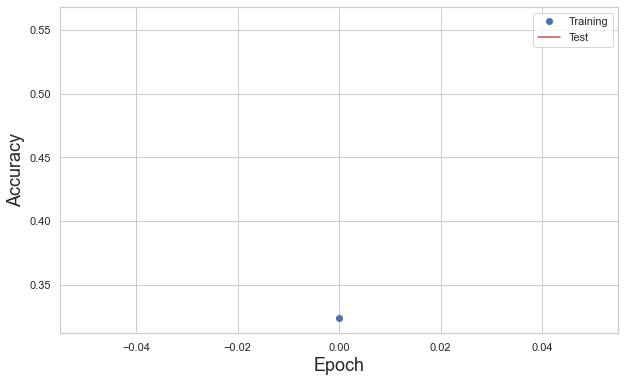

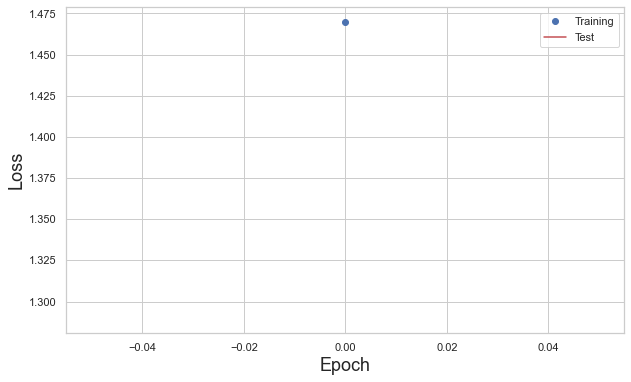

In [20]:
# show the learning process
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epoch_range = range(len(accuracy))

plt.figure(figsize=(10, 6))
plt.plot(epoch_range, accuracy, 'bo', label='Training')
plt.plot(epoch_range, val_accuracy, 'r', label='Test')
plt.xlabel('Epoch', size=18)
plt.ylabel('Accuracy', size=18)
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(epoch_range, loss, 'bo', label='Training')
plt.plot(epoch_range, val_loss, 'r', label='Test')
plt.xlabel('Epoch', size=18)
plt.ylabel('Loss', size=18)
plt.legend()
plt.show()

In [21]:
y_pred = cnn_model.predict(X_test)

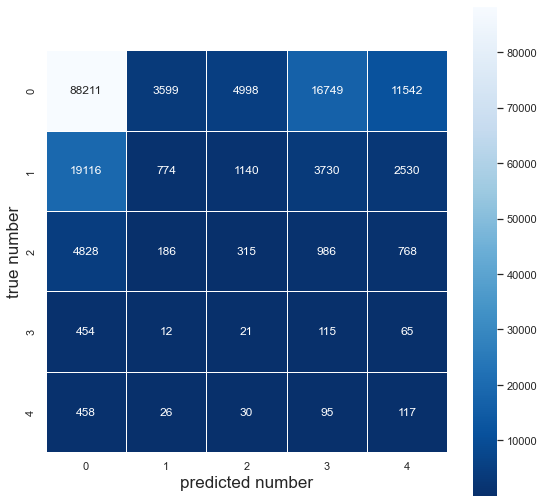

0.5565660647126472

In [22]:
y_test_ = np.argmax(y_test, axis = 1)
y_pred_ = np.argmax(y_pred, axis = 1)

cm1 = confusion_matrix(y_test_, y_pred_)

plt.figure(figsize=(9,9))
sns.heatmap(cm1, annot=True, fmt=".0f", linewidths=.5, square=True, cmap='Blues_r')
plt.ylabel('true number', size=17)
plt.xlabel('predicted number', size=17)
plt.show()

accuracy_score(y_test_, y_pred_)